## Notebook 1: Regression of energy consumption

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

D:\Software\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

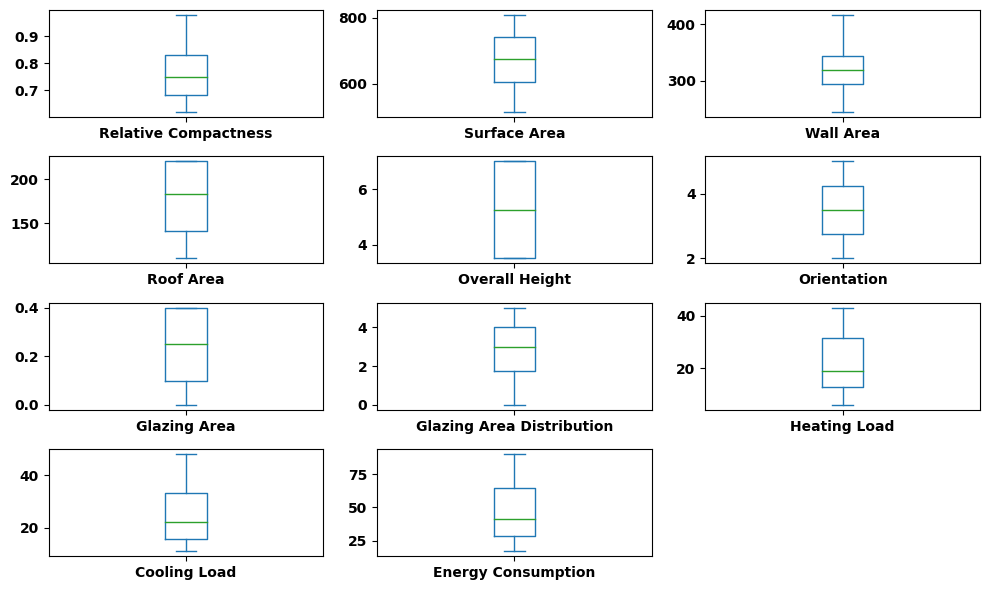

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

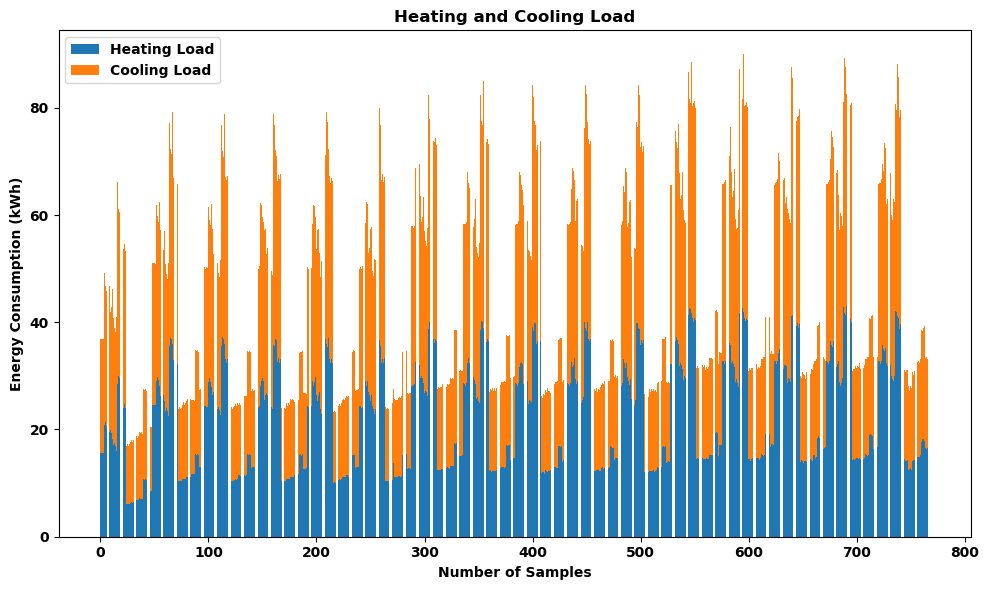

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

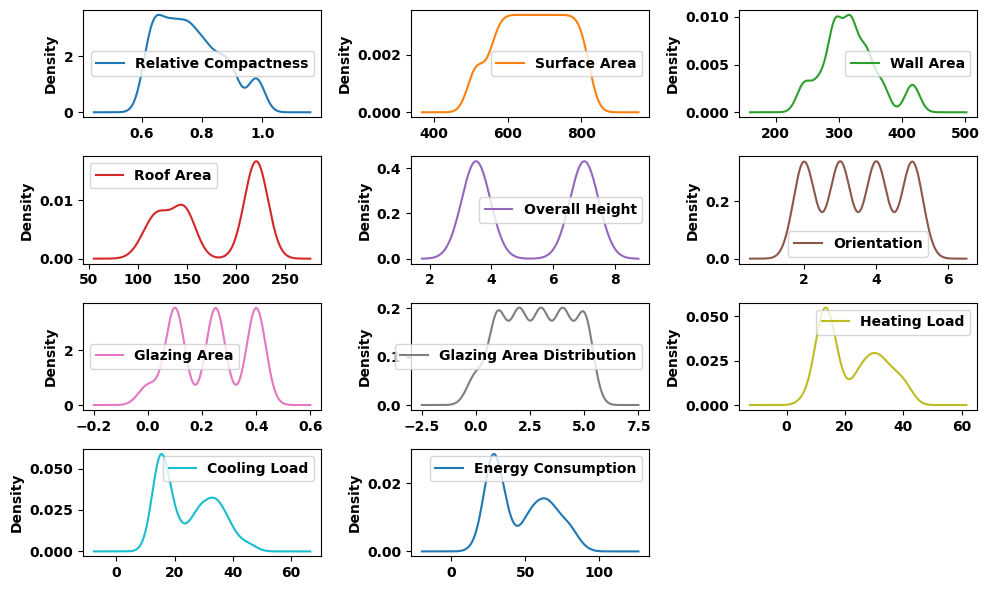

In [8]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

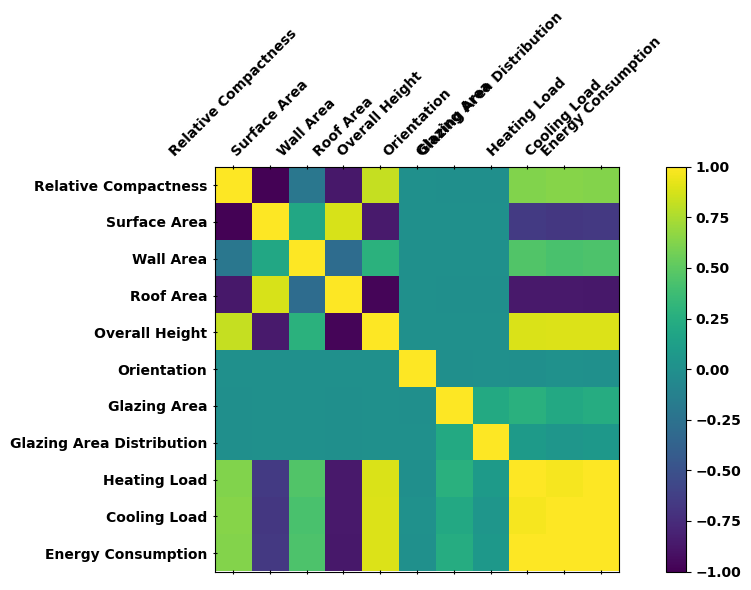

In [9]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [10]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [11]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [12]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# b) Split-out dataset into train and validation sets

X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# For XGBoost model
X_train1 = X_train
y_train1 = y_train
X_val1 = X_val

(537, 8) (537,) (231, 8) (231,)


In [14]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [15]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 3 most popular algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))

# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [16]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (8, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

In [17]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modify loop for xgboost and NN
    if name != ('XGB' and 'NN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        if name == 'NN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})
        else:
            # create DMatrix from training data for XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')
    
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -30.969344 (9.052568)
RF: -3.030389 (0.944267)
XGB: -2.775281 (0.646914)
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpz5kxcinl\assets
Epoch 1/150
4/4 [==============================] - 1s 83ms/step - loss: 2462.1494 - mse: 2462.1494 - val_loss: 2732.9395 - val_mse: 2732.9395
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 2385.2473 - mse: 2385.2473 - val_loss: 2711.2119 - val_mse: 2711.2119
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 2331.3684 - mse: 2331.3684 - val_loss: 2688.9568 - val_mse: 2688.9568
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 2295.7205 - mse: 2295.7205 - val_loss: 2663.9114 - val_mse: 2663.9114
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2261.5491 - mse: 2261.5491 - val_loss: 2637.6619 - val_mse: 2637.6619
Epoch 6/150
4/4 [==============================] - 0s 19ms/step - loss: 2241.9094 - mse: 2241.9094 - val_loss: 2609.0032 - va

4/4 [==============================] - 0s 17ms/step - loss: 1493.7245 - mse: 1493.7247 - val_loss: 1642.3452 - val_mse: 1642.3452
Epoch 58/150
4/4 [==============================] - 0s 16ms/step - loss: 1471.9510 - mse: 1471.9510 - val_loss: 1628.8907 - val_mse: 1628.8907
Epoch 59/150
4/4 [==============================] - 0s 21ms/step - loss: 1456.5675 - mse: 1456.5675 - val_loss: 1614.6976 - val_mse: 1614.6976
Epoch 60/150
4/4 [==============================] - 0s 15ms/step - loss: 1424.9130 - mse: 1424.9130 - val_loss: 1591.4668 - val_mse: 1591.4668
Epoch 61/150
4/4 [==============================] - 0s 17ms/step - loss: 1422.3105 - mse: 1422.3105 - val_loss: 1557.9849 - val_mse: 1557.9849
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 1391.0780 - mse: 1391.0780 - val_loss: 1526.8054 - val_mse: 1526.8054
Epoch 63/150
4/4 [==============================] - 0s 18ms/step - loss: 1361.9561 - mse: 1361.9561 - val_loss: 1498.3158 - val_mse: 1498.3158
Epoch 64/150

4/4 [==============================] - 0s 15ms/step - loss: 280.9922 - mse: 280.9922 - val_loss: 287.5889 - val_mse: 287.5889
Epoch 116/150
4/4 [==============================] - 0s 15ms/step - loss: 284.9306 - mse: 284.9306 - val_loss: 280.0293 - val_mse: 280.0293
Epoch 117/150
4/4 [==============================] - 0s 17ms/step - loss: 269.9578 - mse: 269.9578 - val_loss: 270.9190 - val_mse: 270.9190
Epoch 118/150
4/4 [==============================] - 0s 15ms/step - loss: 259.6517 - mse: 259.6517 - val_loss: 263.8327 - val_mse: 263.8327
Epoch 119/150
4/4 [==============================] - 0s 21ms/step - loss: 244.1543 - mse: 244.1543 - val_loss: 249.0445 - val_mse: 249.0445
Epoch 120/150
4/4 [==============================] - 0s 18ms/step - loss: 237.1744 - mse: 237.1744 - val_loss: 237.5323 - val_mse: 237.5323
Epoch 121/150
4/4 [==============================] - 0s 15ms/step - loss: 214.1326 - mse: 214.1326 - val_loss: 222.4352 - val_mse: 222.4352
Epoch 122/150
4/4 [===============

4/4 [==============================] - 0s 19ms/step - loss: 2014.0002 - mse: 2014.0002 - val_loss: 2218.2051 - val_mse: 2218.2051
Epoch 23/150
4/4 [==============================] - 0s 17ms/step - loss: 2004.2410 - mse: 2004.2410 - val_loss: 2199.3921 - val_mse: 2199.3921
Epoch 24/150
4/4 [==============================] - 0s 15ms/step - loss: 1993.6493 - mse: 1993.6493 - val_loss: 2178.4302 - val_mse: 2178.4302
Epoch 25/150
4/4 [==============================] - 0s 16ms/step - loss: 1975.3824 - mse: 1975.3824 - val_loss: 2158.5291 - val_mse: 2158.5291
Epoch 26/150
4/4 [==============================] - 0s 15ms/step - loss: 1962.2285 - mse: 1962.2285 - val_loss: 2143.6475 - val_mse: 2143.6475
Epoch 27/150
4/4 [==============================] - 0s 15ms/step - loss: 1950.1393 - mse: 1950.1393 - val_loss: 2127.6316 - val_mse: 2127.6316
Epoch 28/150
4/4 [==============================] - 0s 18ms/step - loss: 1946.5620 - mse: 1946.5620 - val_loss: 2115.2109 - val_mse: 2115.2109
Epoch 29/150

4/4 [==============================] - 0s 15ms/step - loss: 949.2064 - mse: 949.2064 - val_loss: 1059.8928 - val_mse: 1059.8928
Epoch 80/150
4/4 [==============================] - 0s 16ms/step - loss: 950.4922 - mse: 950.4922 - val_loss: 1031.9622 - val_mse: 1031.9622
Epoch 81/150
4/4 [==============================] - 0s 15ms/step - loss: 914.5876 - mse: 914.5876 - val_loss: 1002.4808 - val_mse: 1002.4808
Epoch 82/150
4/4 [==============================] - 0s 15ms/step - loss: 903.2245 - mse: 903.2245 - val_loss: 971.3836 - val_mse: 971.3836
Epoch 83/150
4/4 [==============================] - 0s 17ms/step - loss: 860.6906 - mse: 860.6906 - val_loss: 945.2803 - val_mse: 945.2803
Epoch 84/150
4/4 [==============================] - 0s 15ms/step - loss: 855.0016 - mse: 855.0016 - val_loss: 911.4206 - val_mse: 911.4206
Epoch 85/150
4/4 [==============================] - 0s 16ms/step - loss: 827.8046 - mse: 827.8046 - val_loss: 877.1699 - val_mse: 877.1699
Epoch 86/150
4/4 [================

Epoch 138/150
4/4 [==============================] - 0s 16ms/step - loss: 127.7824 - mse: 127.7824 - val_loss: 87.5129 - val_mse: 87.5129
Epoch 139/150
4/4 [==============================] - 0s 18ms/step - loss: 125.8335 - mse: 125.8335 - val_loss: 83.6645 - val_mse: 83.6645
Epoch 140/150
4/4 [==============================] - 0s 18ms/step - loss: 116.9757 - mse: 116.9757 - val_loss: 79.1456 - val_mse: 79.1456
Epoch 141/150
4/4 [==============================] - 0s 16ms/step - loss: 103.8023 - mse: 103.8023 - val_loss: 74.5919 - val_mse: 74.5919
Epoch 142/150
4/4 [==============================] - 0s 18ms/step - loss: 107.6890 - mse: 107.6890 - val_loss: 68.5884 - val_mse: 68.5884
Epoch 143/150
4/4 [==============================] - 0s 17ms/step - loss: 106.9904 - mse: 106.9904 - val_loss: 64.9343 - val_mse: 64.9343
Epoch 144/150
4/4 [==============================] - 0s 20ms/step - loss: 86.6706 - mse: 86.6706 - val_loss: 61.0915 - val_mse: 61.0915
Epoch 145/150
4/4 [=================

Epoch 45/150
4/4 [==============================] - 0s 16ms/step - loss: 1674.4861 - mse: 1674.4861 - val_loss: 1870.7411 - val_mse: 1870.7411
Epoch 46/150
4/4 [==============================] - 0s 17ms/step - loss: 1670.8274 - mse: 1670.8274 - val_loss: 1853.6196 - val_mse: 1853.6196
Epoch 47/150
4/4 [==============================] - 0s 17ms/step - loss: 1650.6191 - mse: 1650.6191 - val_loss: 1833.9880 - val_mse: 1833.9880
Epoch 48/150
4/4 [==============================] - 0s 18ms/step - loss: 1642.5438 - mse: 1642.5438 - val_loss: 1815.7911 - val_mse: 1815.7911
Epoch 49/150
4/4 [==============================] - 0s 17ms/step - loss: 1615.1030 - mse: 1615.1030 - val_loss: 1794.5305 - val_mse: 1794.5305
Epoch 50/150
4/4 [==============================] - 0s 18ms/step - loss: 1612.3414 - mse: 1612.3414 - val_loss: 1780.9277 - val_mse: 1780.9277
Epoch 51/150
4/4 [==============================] - 0s 13ms/step - loss: 1564.3005 - mse: 1564.3005 - val_loss: 1766.6196 - val_mse: 1766.6196

Epoch 103/150
4/4 [==============================] - 0s 17ms/step - loss: 452.6761 - mse: 452.6761 - val_loss: 477.7017 - val_mse: 477.7017
Epoch 104/150
4/4 [==============================] - 0s 17ms/step - loss: 432.5392 - mse: 432.5392 - val_loss: 460.8062 - val_mse: 460.8062
Epoch 105/150
4/4 [==============================] - 0s 16ms/step - loss: 390.5562 - mse: 390.5562 - val_loss: 444.5824 - val_mse: 444.5824
Epoch 106/150
4/4 [==============================] - 0s 16ms/step - loss: 393.0292 - mse: 393.0292 - val_loss: 430.3415 - val_mse: 430.3415
Epoch 107/150
4/4 [==============================] - 0s 18ms/step - loss: 383.1746 - mse: 383.1746 - val_loss: 416.5563 - val_mse: 416.5563
Epoch 108/150
4/4 [==============================] - 0s 16ms/step - loss: 345.4832 - mse: 345.4832 - val_loss: 402.6615 - val_mse: 402.6615
Epoch 109/150
4/4 [==============================] - 0s 17ms/step - loss: 360.3122 - mse: 360.3122 - val_loss: 385.4005 - val_mse: 385.4005
Epoch 110/150
4/4 [=

Epoch 11/150
4/4 [==============================] - 0s 17ms/step - loss: 2210.4309 - mse: 2210.4309 - val_loss: 2468.9761 - val_mse: 2468.9761
Epoch 12/150
4/4 [==============================] - 0s 19ms/step - loss: 2199.0889 - mse: 2199.0889 - val_loss: 2441.5303 - val_mse: 2441.5303
Epoch 13/150
4/4 [==============================] - 0s 17ms/step - loss: 2181.6492 - mse: 2181.6492 - val_loss: 2413.9954 - val_mse: 2413.9954
Epoch 14/150
4/4 [==============================] - 0s 17ms/step - loss: 2160.9126 - mse: 2160.9126 - val_loss: 2388.1775 - val_mse: 2388.1775
Epoch 15/150
4/4 [==============================] - 0s 16ms/step - loss: 2141.9312 - mse: 2141.9312 - val_loss: 2364.3264 - val_mse: 2364.3267
Epoch 16/150
4/4 [==============================] - 0s 16ms/step - loss: 2148.3586 - mse: 2148.3586 - val_loss: 2340.5693 - val_mse: 2340.5693
Epoch 17/150
4/4 [==============================] - 0s 16ms/step - loss: 2123.0776 - mse: 2123.0779 - val_loss: 2317.7244 - val_mse: 2317.7244

4/4 [==============================] - 0s 18ms/step - loss: 1270.9067 - mse: 1270.9067 - val_loss: 1366.3541 - val_mse: 1366.3541
Epoch 69/150
4/4 [==============================] - 0s 16ms/step - loss: 1242.1425 - mse: 1242.1425 - val_loss: 1339.3330 - val_mse: 1339.3330
Epoch 70/150
4/4 [==============================] - 0s 16ms/step - loss: 1222.3359 - mse: 1222.3359 - val_loss: 1314.5135 - val_mse: 1314.5135
Epoch 71/150
4/4 [==============================] - 0s 16ms/step - loss: 1204.0060 - mse: 1204.0060 - val_loss: 1283.1072 - val_mse: 1283.1072
Epoch 72/150
4/4 [==============================] - 0s 16ms/step - loss: 1164.3938 - mse: 1164.3938 - val_loss: 1251.2476 - val_mse: 1251.2476
Epoch 73/150
4/4 [==============================] - 0s 16ms/step - loss: 1137.5021 - mse: 1137.5021 - val_loss: 1220.7037 - val_mse: 1220.7037
Epoch 74/150
4/4 [==============================] - 0s 16ms/step - loss: 1118.3506 - mse: 1118.3506 - val_loss: 1192.3961 - val_mse: 1192.3961
Epoch 75/150

4/4 [==============================] - 0s 18ms/step - loss: 198.9685 - mse: 198.9685 - val_loss: 149.7316 - val_mse: 149.7316
Epoch 127/150
4/4 [==============================] - 0s 18ms/step - loss: 174.1928 - mse: 174.1928 - val_loss: 143.7943 - val_mse: 143.7943
Epoch 128/150
4/4 [==============================] - 0s 18ms/step - loss: 176.4397 - mse: 176.4397 - val_loss: 135.9777 - val_mse: 135.9777
Epoch 129/150
4/4 [==============================] - 0s 19ms/step - loss: 173.7621 - mse: 173.7621 - val_loss: 127.6070 - val_mse: 127.6070
Epoch 130/150
4/4 [==============================] - 0s 18ms/step - loss: 169.9762 - mse: 169.9762 - val_loss: 118.5735 - val_mse: 118.5735
Epoch 131/150
4/4 [==============================] - 0s 18ms/step - loss: 157.6796 - mse: 157.6796 - val_loss: 111.0108 - val_mse: 111.0108
Epoch 132/150
4/4 [==============================] - 0s 17ms/step - loss: 135.9639 - mse: 135.9639 - val_loss: 108.0487 - val_mse: 108.0487
Epoch 133/150
4/4 [===============

4/4 [==============================] - 0s 21ms/step - loss: 1906.2950 - mse: 1906.2950 - val_loss: 2044.2938 - val_mse: 2044.2938
Epoch 34/150
4/4 [==============================] - 0s 19ms/step - loss: 1882.1134 - mse: 1882.1134 - val_loss: 2034.2705 - val_mse: 2034.2705
Epoch 35/150
4/4 [==============================] - 0s 21ms/step - loss: 1868.0548 - mse: 1868.0548 - val_loss: 2021.3428 - val_mse: 2021.3428
Epoch 36/150
4/4 [==============================] - 0s 21ms/step - loss: 1851.6616 - mse: 1851.6616 - val_loss: 2003.4957 - val_mse: 2003.4957
Epoch 37/150
4/4 [==============================] - 0s 19ms/step - loss: 1850.9247 - mse: 1850.9247 - val_loss: 1981.3866 - val_mse: 1981.3866
Epoch 38/150
4/4 [==============================] - 0s 20ms/step - loss: 1840.5519 - mse: 1840.5519 - val_loss: 1966.9960 - val_mse: 1966.9960
Epoch 39/150
4/4 [==============================] - 0s 24ms/step - loss: 1829.6573 - mse: 1829.6573 - val_loss: 1952.3804 - val_mse: 1952.3804
Epoch 40/150

Epoch 91/150
4/4 [==============================] - 0s 26ms/step - loss: 687.8699 - mse: 687.8699 - val_loss: 769.6758 - val_mse: 769.6758
Epoch 92/150
4/4 [==============================] - 0s 28ms/step - loss: 672.5744 - mse: 672.5744 - val_loss: 735.1497 - val_mse: 735.1497
Epoch 93/150
4/4 [==============================] - 0s 23ms/step - loss: 667.3351 - mse: 667.3351 - val_loss: 702.0731 - val_mse: 702.0731
Epoch 94/150
4/4 [==============================] - 0s 22ms/step - loss: 632.8527 - mse: 632.8527 - val_loss: 675.7297 - val_mse: 675.7297
Epoch 95/150
4/4 [==============================] - 0s 22ms/step - loss: 615.6238 - mse: 615.6238 - val_loss: 655.8155 - val_mse: 655.8155
Epoch 96/150
4/4 [==============================] - 0s 22ms/step - loss: 597.5555 - mse: 597.5555 - val_loss: 636.5201 - val_mse: 636.5201
Epoch 97/150
4/4 [==============================] - 0s 24ms/step - loss: 590.2403 - mse: 590.2403 - val_loss: 614.6700 - val_mse: 614.6700
Epoch 98/150
4/4 [=========

Epoch 150/150
1/1 [==============================] - 0s 203ms/step
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp3wuokkt_\assets
Epoch 1/150
4/4 [==============================] - 2s 183ms/step - loss: 2475.9973 - mse: 2475.9973 - val_loss: 2732.5405 - val_mse: 2732.5405
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 2395.9470 - mse: 2395.9470 - val_loss: 2712.3274 - val_mse: 2712.3274
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 2358.0244 - mse: 2358.0247 - val_loss: 2690.9197 - val_mse: 2690.9197
Epoch 4/150
4/4 [==============================] - 0s 20ms/step - loss: 2306.5056 - mse: 2306.5054 - val_loss: 2667.7761 - val_mse: 2667.7761
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 2278.2400 - mse: 2278.2400 - val_loss: 2641.0010 - val_mse: 2641.0010
Epoch 6/150
4/4 [==============================] - 0s 20ms/step - loss: 2250.9492 - mse: 2250.9492 - val_loss: 2612.8142 - val_mse: 26

4/4 [==============================] - 0s 28ms/step - loss: 1611.5468 - mse: 1611.5468 - val_loss: 1749.9091 - val_mse: 1749.9091
Epoch 52/150
4/4 [==============================] - 0s 25ms/step - loss: 1616.4700 - mse: 1616.4700 - val_loss: 1727.0159 - val_mse: 1727.0159
Epoch 53/150
4/4 [==============================] - 0s 24ms/step - loss: 1601.4579 - mse: 1601.4579 - val_loss: 1710.0645 - val_mse: 1710.0645
Epoch 54/150
4/4 [==============================] - 0s 27ms/step - loss: 1565.5006 - mse: 1565.5006 - val_loss: 1692.2999 - val_mse: 1692.2999
Epoch 55/150
4/4 [==============================] - 0s 33ms/step - loss: 1547.1725 - mse: 1547.1725 - val_loss: 1676.2992 - val_mse: 1676.2992
Epoch 56/150
4/4 [==============================] - 0s 26ms/step - loss: 1522.9285 - mse: 1522.9285 - val_loss: 1665.5828 - val_mse: 1665.5828
Epoch 57/150
4/4 [==============================] - 0s 25ms/step - loss: 1510.0753 - mse: 1510.0753 - val_loss: 1654.3123 - val_mse: 1654.3123
Epoch 58/150

4/4 [==============================] - 0s 26ms/step - loss: 378.2048 - mse: 378.2048 - val_loss: 400.4132 - val_mse: 400.4132
Epoch 110/150
4/4 [==============================] - 0s 28ms/step - loss: 348.2789 - mse: 348.2789 - val_loss: 386.7896 - val_mse: 386.7896
Epoch 111/150
4/4 [==============================] - 0s 29ms/step - loss: 349.7223 - mse: 349.7223 - val_loss: 370.6584 - val_mse: 370.6584
Epoch 112/150
4/4 [==============================] - 0s 26ms/step - loss: 323.8793 - mse: 323.8793 - val_loss: 362.8517 - val_mse: 362.8517
Epoch 113/150
4/4 [==============================] - 0s 36ms/step - loss: 329.1498 - mse: 329.1498 - val_loss: 351.1940 - val_mse: 351.1940
Epoch 114/150
4/4 [==============================] - 0s 34ms/step - loss: 323.0190 - mse: 323.0190 - val_loss: 332.0955 - val_mse: 332.0955
Epoch 115/150
4/4 [==============================] - 0s 36ms/step - loss: 290.6549 - mse: 290.6549 - val_loss: 313.6779 - val_mse: 313.6779
Epoch 116/150
4/4 [===============

Epoch 12/150
4/4 [==============================] - 0s 27ms/step - loss: 2069.5359 - mse: 2069.5359 - val_loss: 2438.8655 - val_mse: 2438.8655
Epoch 13/150
4/4 [==============================] - 0s 27ms/step - loss: 2058.2507 - mse: 2058.2507 - val_loss: 2409.4749 - val_mse: 2409.4749
Epoch 14/150
4/4 [==============================] - 0s 27ms/step - loss: 2043.6680 - mse: 2043.6680 - val_loss: 2382.6997 - val_mse: 2382.7000
Epoch 15/150
4/4 [==============================] - 0s 27ms/step - loss: 2030.5773 - mse: 2030.5773 - val_loss: 2357.8291 - val_mse: 2357.8291
Epoch 16/150
4/4 [==============================] - 0s 26ms/step - loss: 2015.1886 - mse: 2015.1886 - val_loss: 2334.3435 - val_mse: 2334.3433
Epoch 17/150
4/4 [==============================] - 0s 23ms/step - loss: 2024.8262 - mse: 2024.8262 - val_loss: 2313.8816 - val_mse: 2313.8816
Epoch 18/150
4/4 [==============================] - 0s 24ms/step - loss: 1993.7928 - mse: 1993.7928 - val_loss: 2295.5515 - val_mse: 2295.5515

4/4 [==============================] - 0s 24ms/step - loss: 1169.1187 - mse: 1169.1187 - val_loss: 1306.4379 - val_mse: 1306.4379
Epoch 70/150
4/4 [==============================] - 0s 22ms/step - loss: 1154.6344 - mse: 1154.6344 - val_loss: 1277.2535 - val_mse: 1277.2535
Epoch 71/150
4/4 [==============================] - 0s 23ms/step - loss: 1119.7766 - mse: 1119.7766 - val_loss: 1250.3458 - val_mse: 1250.3457
Epoch 72/150
4/4 [==============================] - 0s 22ms/step - loss: 1104.7141 - mse: 1104.7141 - val_loss: 1225.2740 - val_mse: 1225.2740
Epoch 73/150
4/4 [==============================] - 0s 23ms/step - loss: 1061.5426 - mse: 1061.5426 - val_loss: 1204.7538 - val_mse: 1204.7538
Epoch 74/150
4/4 [==============================] - 0s 22ms/step - loss: 1056.0552 - mse: 1056.0552 - val_loss: 1183.5264 - val_mse: 1183.5264
Epoch 75/150
4/4 [==============================] - 0s 22ms/step - loss: 1020.6554 - mse: 1020.6554 - val_loss: 1163.0364 - val_mse: 1163.0364
Epoch 76/150

4/4 [==============================] - 0s 27ms/step - loss: 166.0251 - mse: 166.0251 - val_loss: 148.1180 - val_mse: 148.1180
Epoch 128/150
4/4 [==============================] - 0s 21ms/step - loss: 159.3193 - mse: 159.3193 - val_loss: 139.4136 - val_mse: 139.4136
Epoch 129/150
4/4 [==============================] - 0s 25ms/step - loss: 153.3521 - mse: 153.3521 - val_loss: 133.8262 - val_mse: 133.8262
Epoch 130/150
4/4 [==============================] - 0s 21ms/step - loss: 139.7773 - mse: 139.7773 - val_loss: 128.6514 - val_mse: 128.6514
Epoch 131/150
4/4 [==============================] - 0s 19ms/step - loss: 141.9221 - mse: 141.9221 - val_loss: 123.1704 - val_mse: 123.1704
Epoch 132/150
4/4 [==============================] - 0s 19ms/step - loss: 139.6886 - mse: 139.6886 - val_loss: 117.8515 - val_mse: 117.8515
Epoch 133/150
4/4 [==============================] - 0s 24ms/step - loss: 134.1398 - mse: 134.1398 - val_loss: 112.6873 - val_mse: 112.6873
Epoch 134/150
4/4 [===============

4/4 [==============================] - 0s 24ms/step - loss: 1883.8346 - mse: 1883.8346 - val_loss: 2061.8091 - val_mse: 2061.8091
Epoch 35/150
4/4 [==============================] - 0s 24ms/step - loss: 1876.5880 - mse: 1876.5880 - val_loss: 2041.6926 - val_mse: 2041.6926
Epoch 36/150
4/4 [==============================] - 0s 24ms/step - loss: 1856.1742 - mse: 1856.1742 - val_loss: 2021.2601 - val_mse: 2021.2601
Epoch 37/150
4/4 [==============================] - 0s 24ms/step - loss: 1851.1613 - mse: 1851.1613 - val_loss: 1999.5002 - val_mse: 1999.5002
Epoch 38/150
4/4 [==============================] - 0s 24ms/step - loss: 1833.2096 - mse: 1833.2096 - val_loss: 1981.7351 - val_mse: 1981.7351
Epoch 39/150
4/4 [==============================] - 0s 22ms/step - loss: 1806.2056 - mse: 1806.2056 - val_loss: 1967.3092 - val_mse: 1967.3092
Epoch 40/150
4/4 [==============================] - 0s 23ms/step - loss: 1796.7677 - mse: 1796.7677 - val_loss: 1955.5482 - val_mse: 1955.5482
Epoch 41/150

4/4 [==============================] - 0s 25ms/step - loss: 703.0968 - mse: 703.0968 - val_loss: 800.1320 - val_mse: 800.1320
Epoch 92/150
4/4 [==============================] - 0s 26ms/step - loss: 673.8082 - mse: 673.8082 - val_loss: 776.7614 - val_mse: 776.7614
Epoch 93/150
4/4 [==============================] - 0s 25ms/step - loss: 648.8989 - mse: 648.8989 - val_loss: 758.7242 - val_mse: 758.7242
Epoch 94/150
4/4 [==============================] - 0s 24ms/step - loss: 646.9445 - mse: 646.9445 - val_loss: 741.2215 - val_mse: 741.2215
Epoch 95/150
4/4 [==============================] - 0s 24ms/step - loss: 650.7908 - mse: 650.7908 - val_loss: 721.1461 - val_mse: 721.1461
Epoch 96/150
4/4 [==============================] - 0s 24ms/step - loss: 584.7130 - mse: 584.7130 - val_loss: 700.3856 - val_mse: 700.3856
Epoch 97/150
4/4 [==============================] - 0s 20ms/step - loss: 580.9130 - mse: 580.9130 - val_loss: 675.1262 - val_mse: 675.1262
Epoch 98/150
4/4 [======================

Epoch 150/150
1/1 [==============================] - 0s 157ms/step
NN: -49.443072 (12.384181)


Epoch 1/500
5/5 [==============================] - 2s 52ms/step - loss: 2453.0205 - mse: 2453.0205 - val_loss: 2726.2322 - val_mse: 2726.2322
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 2366.7749 - mse: 2366.7749 - val_loss: 2700.9968 - val_mse: 2700.9968
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 2324.8918 - mse: 2324.8918 - val_loss: 2675.9583 - val_mse: 2675.9583
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 2287.1018 - mse: 2287.1018 - val_loss: 2648.0166 - val_mse: 2648.0166
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 2248.7427 - mse: 2248.7427 - val_loss: 2617.1116 - val_mse: 2617.1116
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 2222.2319 - mse: 2222.2319 - val_loss: 2583.1042 - val_mse: 2583.1042
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 2197.7844 - mse: 2197.7844 - val_loss: 2548.3809 - val_mse: 2548.3809
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 1173.4395 - mse: 1173.4395 - val_loss: 1255.2223 - val_mse: 1255.2222
Epoch 59/500
5/5 [==============================] - 0s 19ms/step - loss: 1157.1633 - mse: 1157.1633 - val_loss: 1230.1974 - val_mse: 1230.1974
Epoch 60/500
5/5 [==============================] - 0s 19ms/step - loss: 1105.8722 - mse: 1105.8722 - val_loss: 1192.9742 - val_mse: 1192.9742
Epoch 61/500
5/5 [==============================] - 0s 20ms/step - loss: 1096.0020 - mse: 1096.0020 - val_loss: 1156.8184 - val_mse: 1156.8182
Epoch 62/500
5/5 [==============================] - 0s 18ms/step - loss: 1046.6588 - mse: 1046.6588 - val_loss: 1123.8208 - val_mse: 1123.8208
Epoch 63/500
5/5 [==============================] - 0s 23ms/step - loss: 1021.0406 - mse: 1021.0406 - val_loss: 1083.8328 - val_mse: 1083.8328
Epoch 64/500
5/5 [==============================] - 0s 26ms/step - loss: 999.6697 - mse: 999.6697 - val_loss: 1036.6130 - val_mse: 1036.6130
Epoch 65/500
5

Epoch 117/500
5/5 [==============================] - 0s 25ms/step - loss: 101.7947 - mse: 101.7947 - val_loss: 71.2892 - val_mse: 71.2892
Epoch 118/500
5/5 [==============================] - 0s 28ms/step - loss: 101.0475 - mse: 101.0475 - val_loss: 68.7779 - val_mse: 68.7779
Epoch 119/500
5/5 [==============================] - 0s 26ms/step - loss: 104.7995 - mse: 104.7995 - val_loss: 62.4339 - val_mse: 62.4339
Epoch 120/500
5/5 [==============================] - 0s 28ms/step - loss: 104.4136 - mse: 104.4136 - val_loss: 56.0693 - val_mse: 56.0693
Epoch 121/500
5/5 [==============================] - 0s 26ms/step - loss: 86.5887 - mse: 86.5887 - val_loss: 53.5922 - val_mse: 53.5922
Epoch 122/500
5/5 [==============================] - 0s 30ms/step - loss: 93.4662 - mse: 93.4662 - val_loss: 50.6775 - val_mse: 50.6775
Epoch 123/500
5/5 [==============================] - 0s 28ms/step - loss: 80.5168 - mse: 80.5168 - val_loss: 48.3482 - val_mse: 48.3482
Epoch 124/500
5/5 [=====================

5/5 [==============================] - 0s 25ms/step - loss: 55.2094 - mse: 55.2094 - val_loss: 16.3765 - val_mse: 16.3765
Epoch 178/500
5/5 [==============================] - 0s 26ms/step - loss: 60.3537 - mse: 60.3537 - val_loss: 15.8348 - val_mse: 15.8348
Epoch 179/500
5/5 [==============================] - 0s 28ms/step - loss: 49.4432 - mse: 49.4432 - val_loss: 16.2180 - val_mse: 16.2180
Epoch 180/500
5/5 [==============================] - 0s 25ms/step - loss: 59.5273 - mse: 59.5273 - val_loss: 15.7396 - val_mse: 15.7396
Epoch 181/500
5/5 [==============================] - 0s 25ms/step - loss: 50.9396 - mse: 50.9396 - val_loss: 15.5116 - val_mse: 15.5116
Epoch 182/500
5/5 [==============================] - 0s 25ms/step - loss: 53.4939 - mse: 53.4939 - val_loss: 16.6554 - val_mse: 16.6554
Epoch 183/500
5/5 [==============================] - 0s 26ms/step - loss: 59.4963 - mse: 59.4963 - val_loss: 16.9101 - val_mse: 16.9101
Epoch 184/500
5/5 [==============================] - 0s 26ms/s

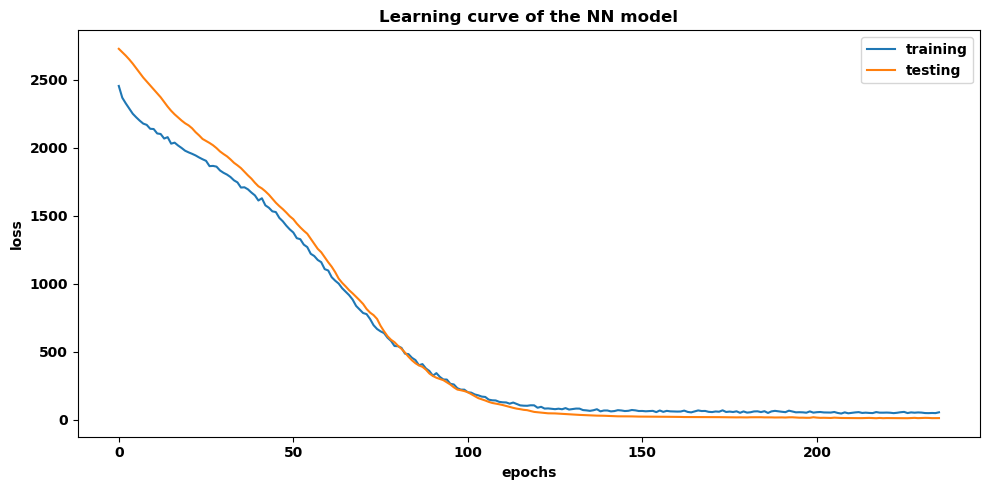

In [19]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

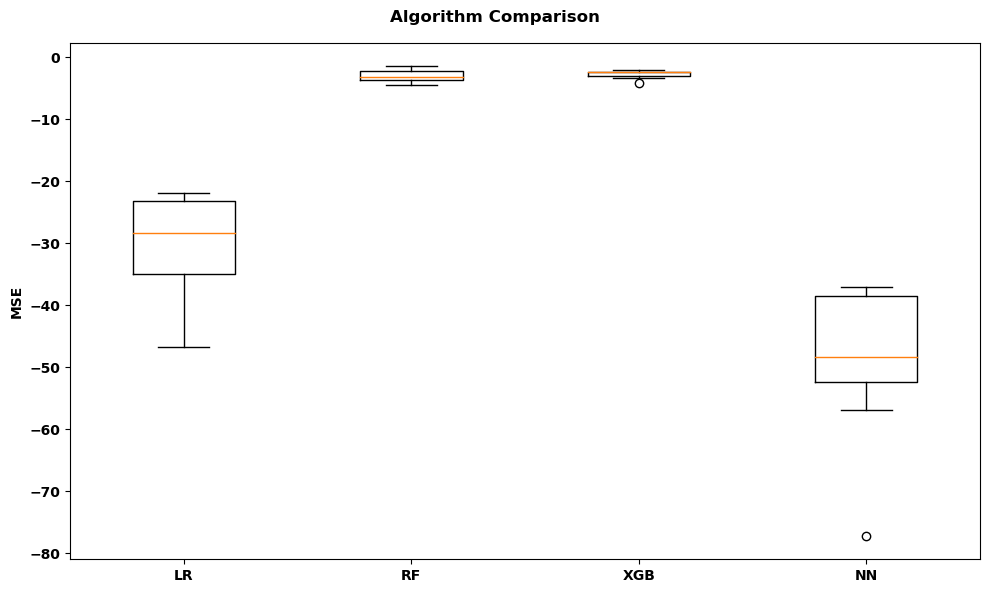

In [20]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

Of the three algorithms and NN model, the ensemble models outperformed Linear Regression and NN model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [21]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  1.2351385281385276


In [22]:
# Evaluate performance of XGBoost algorithm on validation data
model_xgb.fit(X_train1, y_train1)
dtrain = xgb.DMatrix(X_val1)
y_pred_xgb = model_xgb.predict(X_val1)
mae_pred_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("Mean Absolute Error of predicted data: ", mae_pred_xgb)

Mean Absolute Error of predicted data:  1.412210528551242


In [23]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  17.70811874323593


The resulting MAE values show that Random Forest looks better than XGBoost in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the optimization process in the 2nd Notebook.

**5. Finalize Model**

In [24]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


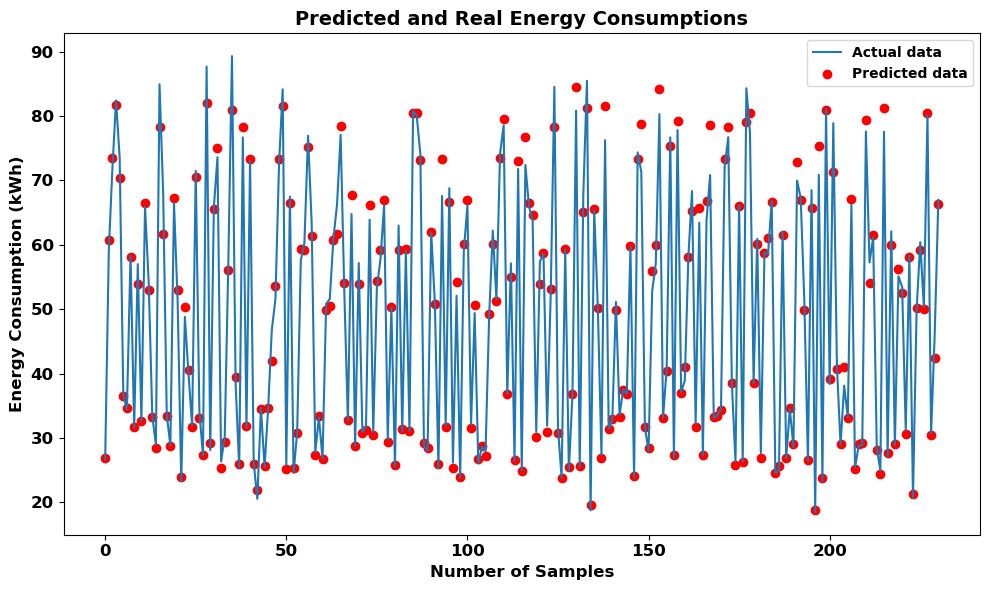

In [25]:
fig, ax = plt.subplots()

# Plot the actual data as a line chart
ax.plot(range(len(y_val)), y_val, label='Actual data')

# Overlay the predicted data as a scatter plot
ax.scatter(range(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')

# Add labels, title, and legend
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Predicted and Real Energy Consumptions', fontsize=14)
ax.legend()

# set tick font size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [26]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis shows that most input variables exhibit non-Gaussian distribution.

- Among the three machine learning algorithms and neural network (NN) model, Random Forest and XGBoost attained lowest Mean Squared Error values following cross validation process. The Random Forest algorithm was selected as the surrogate model for optimization process in the 2nd Notebook.

- The Mean Absolute Error values indicate that the prediction accuracy for the ensemble algorithms is excellent, whereas it was unexpectedly low for the NN model.

- The performance of the NN model (Keras Sequential) is worst than all ML algorithms. Further tunning of the hyperparameter may yield a better prediction score.